## makemore: part 5.b

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [6]:
from dataclasses import dataclass

# build the dataset
block_size = 8  # context length: how many characters do we take to predict the next one?

@dataclass
class Dataset:
    x: torch.tensor
    y: torch.tensor

@dataclass
class Datasets:
    train: Dataset
    dev: Dataset
    test: Dataset

def build_dataset(words) -> Dataset:
    xs, ys = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)
            context = context[1:] + [ix]  # crop and append

    ds = Dataset(torch.tensor(xs), torch.tensor(ys))
    print(ds.x.shape, ds.y.shape)
    return ds

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
datasets = Datasets(
    build_dataset(words[:n1]),    # 80%,
    build_dataset(words[n1:n2]),  # 10%
    build_dataset(words[n2:])     # 10%
)

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
for x, y in zip(datasets.train.x[:20], datasets.train.y[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [192]:
from abc import ABC, abstractmethod

torch.manual_seed(42)


class Layer(ABC):
    def __init__(self):
        self.training = True
        self.out = None

    @abstractmethod
    def __call__(self, x: torch.Tensor):
        pass
    
    def backward(self):
        for p in self.parameters():
            p.grad = None

    @abstractmethod
    def parameters(self):
        return []


class Linear(Layer):
    def __init__(self, fan_in, fan_out, bias=False):
        super().__init__()
        self.w = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.b = torch.zeros(fan_out) if bias else None

    def __call__(self, x: torch.Tensor):
        self.out = x @ self.w
        if self.b is not None:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.w] + ([self.b] if self.b is not None else [])


class Tanh(Layer):
    def __call__(self, x: torch.Tensor):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class Embedding(Layer):
    def __init__(self, num_embeddings: int, embedding_dim: int):
        super().__init__()
        self.w = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, x: torch.Tensor):
        self.out = self.w[x]
        return self.out

    def parameters(self):
        return [self.w]


class FlattenConsecutive(Layer):
    def __init__(self, n: int | None = None):
        super().__init__()
        self.n = n

    def __call__(self, x: torch.Tensor):
        if self.n:
            self.out = x.view(x.shape[0], x.shape[1] // self.n, x.shape[2] * self.n)
            if self.out.shape[1] == 1:
                self.out = self.out.squeeze(dim=1)
        else:
            self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []


class BatchNorm1d(Layer):
    def __init__(self, n_dim: int, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        super().__init__()
        # parameters
        self.gain = torch.ones(n_dim)
        self.bias = torch.zeros(n_dim)
        # buffers
        self.running_mean = torch.zeros(n_dim)
        self.running_var = torch.ones(n_dim)

    def __call__(self, x: torch.Tensor):
        if self.training:
            assert x.shape[0] > 1, 'Minibatch size must be larger than 1'
            assert 2 <= x.ndim <= 3, x.ndim 
            dim = 0
            if x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / (xvar + self.eps) ** 0.5
        # normalise to a unit gaussian
        self.out = xhat * self.gain + self.bias
        
        if self.training:
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gain, self.bias]


class Sequential:
    def __init__(self, layers: list[Layer]):
        self.layers = layers
        self.out = None
        
    def __call__(self, x: torch.Tensor, training: bool = False) -> torch.Tensor:
        for l in self.layers:
            l.training = training
            # print(f'{l.__class__.__name__}, {x.shape=}')
            x = l(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]


n_embd = 10
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2,   n_hidden,     bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden),     Tanh(),
    Linear(n_hidden, vocab_size),
])
with torch.no_grad():
    if isinstance(model.layers[-1], BatchNorm1d):
        model.layers[-1].gain *= 0.1
    if isinstance(model.layers[-1], Linear):
        model.layers[-1].w *= 0.1
    
    for l in model.layers:
        if isinstance(l, Linear):
            # tanh is a shrinking function, so need to initialise wights a bit larger
            # to compensate this shrinkage and keep weights a unit gaussian on each step
            l.w *= 5/3

for p in model.parameters():
    p.requires_grad = True

print('Total model parameters:', sum(p.nelement() for p in model.parameters()))

Total model parameters: 22370


In [191]:
xi = torch.randint(low=0, high=len(datasets.train.x), size=(4,))
xb = datasets.train.x[xi]
emb_l = Embedding(vocab_size, n_embd)
print(f'{xb.shape=}, {emb_l.w.shape=}')
emb = emb_l(xb)

embcat = emb.view(xb.shape[0], -1, n_embd * 4)
print(f'{emb.shape=}')
l1 = Linear(n_embd * 4, n_hidden, bias=False)
h1 = Tanh()(l1(embcat))
xmean = h1.mean(tuple(range(len(h1.shape) - 1)), keepdim=True)
print(f'{xmean.shape=}')

x2 = h1.view(h1.shape[0], -1, n_hidden * 2)
print(f'{x2.shape=}')
l2 = Linear(n_hidden * 2, n_hidden, bias=False)
print(f'{l2.w.shape=}')
h2 = Tanh()(l2(x2))
print(f'{h2.shape=}')

x3 = h1.view(h1.shape[0], -1, n_hidden * 2)
x3 = x3.squeeze(1)
print(f'{x3.shape=}')
l3 = Linear(n_hidden * 2, n_hidden, bias=False)
print(f'{l3.w.shape=}')
h3 = Tanh()(l3(x3))
print(f'{h3.shape=}')

xb.shape=torch.Size([4, 8]), emb_l.w.shape=torch.Size([27, 10])
emb.shape=torch.Size([4, 8, 10])
xmean.shape=torch.Size([1, 1, 68])
x2.shape=torch.Size([4, 1, 136])
l2.w.shape=torch.Size([136, 68])
h2.shape=torch.Size([4, 1, 68])
x3.shape=torch.Size([4, 136])
l3.w.shape=torch.Size([136, 68])
h3.shape=torch.Size([4, 68])


In [195]:
DEBUG = False

from collections import defaultdict

n_steps = 10001
batch_size = 32
learning_rate = 0.1

# stats
linear_w_update_rates_by_layer = defaultdict(list)
losses = []
tanh_outs = []


for step_i in range(n_steps):
    batch_ix = torch.randint(high=datasets.train.x.shape[0], size=(batch_size,))
    xb = datasets.train.x[batch_ix]
    yb = datasets.train.y[batch_ix]
    logits = model(xb, training=True)
    loss = F.cross_entropy(logits, yb)

    if DEBUG:
        for l in model.layers:
            l.out.retain_grad()

    if n_steps == 1 or step_i % (n_steps // 10) == 0:
        print(f'Step {step_i}: training loss: {loss.item()}')
    losses.append(loss.item())

    for p in model.parameters():
        p.grad = None
    loss.backward()

    lr = learning_rate if (step_i < (n_steps / 2)) else learning_rate / 10
    for p in model.parameters():
        p.data -= lr * p.grad

    if DEBUG:
        with torch.no_grad():
            for li, l in enumerate(model.layers):
                ps = [p for p in l.parameters() if len(p.shape) == 2]
                if ps:
                    linear_w_update_rates_by_layer[li].append(
                        (lr * ps[0].grad.std() / ps[0].data.std()).abs().log10().item()
                    )
            if n_steps == 1 or step_i % (n_steps // 10) == 0:
                last_tanh = [l for l in model.layers if isinstance(l, Tanh)][-1]
                tanh_outs.append(last_tanh.out)


@torch.no_grad()
def loss_for_split(split: str):
    ds = datasets.__getattribute__(split)
    logits = model(ds.x)
    loss = F.cross_entropy(logits, ds.y)
    print(f'{split} loss={loss}')

if not DEBUG:
    loss_for_split('train')
    loss_for_split('test')
    loss_for_split('dev')


Step 0: training loss: 2.712210178375244
Step 1000: training loss: 2.356775999069214
Step 2000: training loss: 1.886745572090149
Step 3000: training loss: 2.159053087234497
Step 4000: training loss: 2.0908851623535156
Step 5000: training loss: 2.127516269683838
Step 6000: training loss: 1.9764575958251953
Step 7000: training loss: 2.197605848312378
Step 8000: training loss: 2.2123000621795654
Step 9000: training loss: 2.2687690258026123
Step 10000: training loss: 2.06207013130188
train loss=2.150923252105713
test loss=2.1620776653289795
dev loss=2.1689047813415527


Reshaped: torch.Size([1000, 10]), means shape: torch.Size([1000])


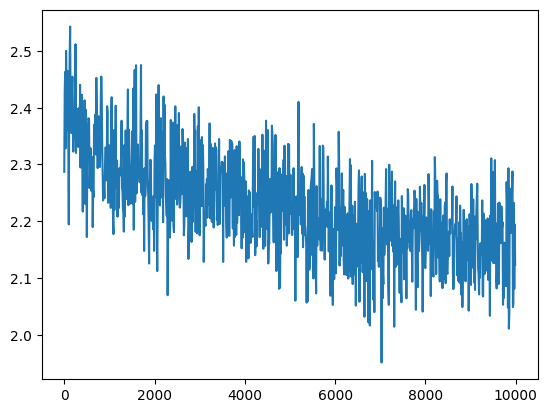

In [196]:
# e.g. for 10_000 steps, it would be 10, so we plot every 10 steps
window_size = n_steps // 1000
# taking mean for every 10 steps
t = torch.tensor(losses[:-1]).view(-1, window_size)
print(f'Reshaped: {t.shape}, means shape: {t.mean(1).shape}')
plt.plot(torch.arange(len(t)) * window_size, t.mean(1));

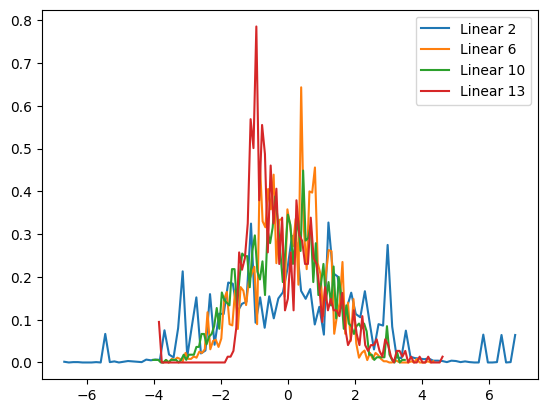

In [187]:
# Linear layers outs should stay close to unit gaussian. If they are not,
# it means that the initialisation is wrong, and/or batch norm is wrong.
legends = []
for li, l in enumerate(model.layers):
    if isinstance(l, Linear):
        hy, hx = torch.histogram(l.out, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{l.__class__.__name__} {li}')
plt.legend(legends);

step 1   : t.mean().item()=+0.0000  t.std().item()=+0.6322  +0.0322
step 101 : t.mean().item()=+0.0052  t.std().item()=+0.6535  +0.0161
step 201 : t.mean().item()=-0.0074  t.std().item()=+0.6420  +0.0290
step 301 : t.mean().item()=-0.0025  t.std().item()=+0.6667  +0.0326
step 401 : t.mean().item()=+0.0001  t.std().item()=+0.6641  +0.0271
step 501 : t.mean().item()=+0.0003  t.std().item()=+0.6659  +0.0290
step 601 : t.mean().item()=+0.0025  t.std().item()=+0.6653  +0.0262
step 701 : t.mean().item()=-0.0139  t.std().item()=+0.6567  +0.0253
step 801 : t.mean().item()=+0.0028  t.std().item()=+0.6766  +0.0244
step 901 : t.mean().item()=-0.0012  t.std().item()=+0.6614  +0.0290
step 1001: t.mean().item()=+0.0007  t.std().item()=+0.6781  +0.0221


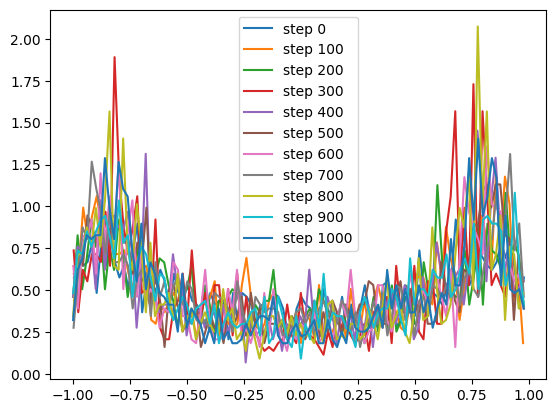

In [188]:
# Hist of tanh outputs over time. 
# Tanh of a gaussian with long tails will have peaks close to -1 and 1, 
# meaning that such neurons won't train and will saturate i.e. any small 
# change to a large input of tanh wouldn't change the output.
# So we should not expect to see very high peaks of tanh.
legends = []
for i, t in enumerate(tanh_outs):
    legends.append(f'step {i * (n_steps // 10)}')
    counts, xs = torch.histogram(t, density=True)
    plt.plot(xs[:-1].detach(), counts.detach())

    sat = (t.abs() > 0.97).float().mean().item()
    print(f'step {i * (n_steps // 10) + 1:<4}: {t.mean().item()=:+.4f}  {t.std().item()=:+.4f}  {sat:+.4f}')
plt.legend(legends);

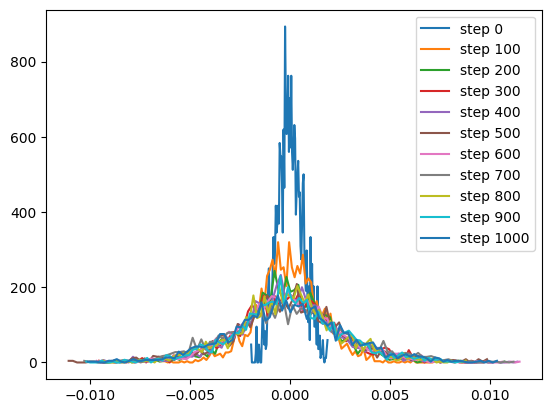

In [189]:
# Histogram of tanh output gradients. Following the reasoning above, we 
# shouldn't see a lot at zero.
legends = []
for i, t in enumerate(tanh_outs):
    counts, xs = torch.histogram(t.grad, density=True)
    plt.plot(xs[:-1].detach(), counts.detach())
    legends.append(f'step {i * (n_steps // 10)}')
plt.legend(legends);

weight (27, 10)  : mean: +0.0000, std: 0.0123, grad:data: -0.0211
weight (20, 68)  : mean: +0.0001, std: 0.0123, grad:data: +0.1895
weight (136, 68) : mean: +0.0001, std: 0.0086, grad:data: -0.0997
weight (136, 68) : mean: -0.0001, std: 0.0062, grad:data: +0.0664
weight (68, 27)  : mean: +0.0000, std: 0.0231, grad:data: -0.3798


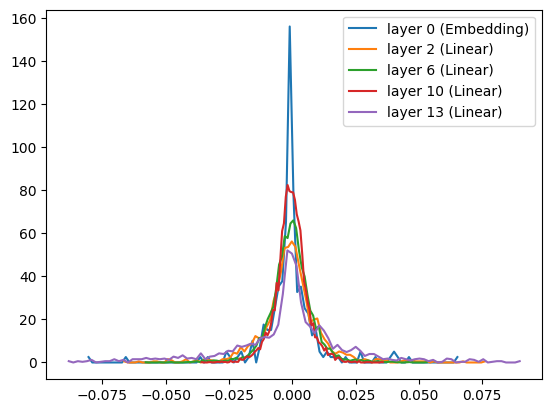

In [164]:
# Histogram of weights gradients for each layer (not over time).
legends = []
for li, l in enumerate(model.layers):
    if isinstance(l, Linear) or isinstance(l, Embedding):
        print(
            f'weight {str(tuple(l.w.shape)):<10}: '
            f'mean: {l.w.grad.mean().item():+.4f}, std: {l.w.grad.std().item():.4f}, '
            f'grad:data: {(l.w.grad / l.w.data).mean().item():+.4f}'
        )
        w_grad_count, w_grad = torch.histogram(l.w.grad, density=True)
        plt.plot(w_grad[:-1].detach(), w_grad_count.detach())
        legends.append(f'layer {li} ({l.__class__.__name__})')
plt.legend(legends);

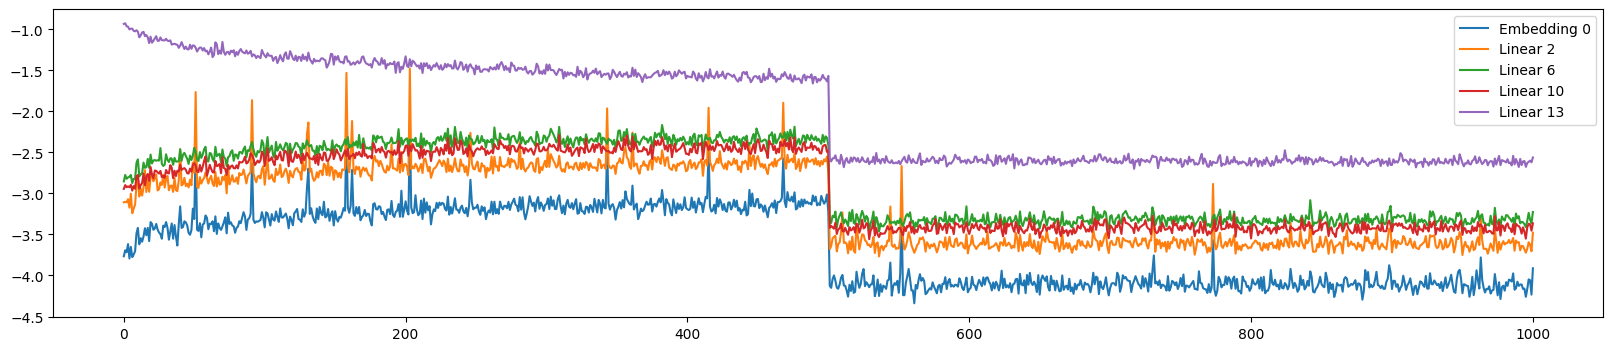

In [165]:
# Plotting update rate over step, for each layer. Ideal update rate should be 
# around 1/1000 which corresponds to the factor of -3 on the plot. Meaning, 
# that the update (learning rate std times gradient std?) is 1/1000th of data.
plt.figure(figsize=(20, 4))
legends = []
for li, l in enumerate(model.layers):
    if isinstance(l, Linear) or isinstance(l, Embedding):
        t = linear_w_update_rates_by_layer[li]
        plt.plot(t)
        legends.append(f'{l.__class__.__name__} {li}')
plt.plot([0, len(linear_w_update_rates_by_layer[1])], [-3, -3], 'k')
plt.legend(legends);


In [197]:
# sample from the model
max_words = 20
max_word_len = 20
for _ in range(max_words):
    out = []
    context = [0] * block_size
    for _ in range(max_word_len):
        x = torch.tensor([context])
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        assert torch.all(probs >= 0), logits
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[ix] for ix in out))


daelee.
grandig.
ariahu.
anslein.
isuban.
ayharin.
elirah.
merkari.
najden.
loraz.
kalina.
kyrdch.
arlan.
bmeshad.
iajman.
jambrer.
soma.
amonylen.
emevea.
lazie.
